# COMPX523-24A (HAM) Assignment 3
---
<br>

> Name: Joseph Dehn
>> ID: 1571787

> Name: Yuqing Deng
>> ID: 1580744

> Name: Sudharshanam Neelakandan Ravi
>> ID: 1631517

---



**Install the required modules**

In [ ]:
!pip install capymoa

In [ ]:
# this module implements functions to read and write ARFF files in Python
!pip install liac-arff

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=722829735603d7d349c582b0a9e0316b4a363b2696ccf6130fabefc922197064
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


**Import the required libraries**

In [ ]:
import capymoa
import capymoa.stream
from capymoa.stream import ARFFStream, Schema
from capymoa.regressor import AdaptiveRandomForestRegressor,KNNRegressor, FIMTDD, SGDRegressor, SOKNL
from capymoa.evaluation import prequential_evaluation
import arff

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings



**Load the data**


In [ ]:
# load the dataset
file_path = 'MHPA-docs-data.csv'
data = pd.read_csv(file_path)


In [ ]:
# display the data
data

,TmStamp,RecNum,batt_volt,mean_wind_speed,mean_wind_direction,std_wind_dir,Max_Gust_Min,Max_Gust_Hr,Rain_mm,Barametric_Avg,Air_Temp_Avg,RH_Avg,SlrW_Avg,SlrMJ_Tot,in_bytes_str,Dew_Point_Avg
0,2011-03-25 08:17:00.0000000,0,13.21,NaN,0.000000,0.000000,NaN,0.000000,0.0,1021.965759,8.23,88.500000,261.799988,0.000785,NaN,NaN
1,2011-03-25 08:18:00.0000000,1,13.21,NaN,0.000000,0.000000,NaN,6.726000,0.0,1021.638794,8.24,88.699997,263.500000,0.015810,"Q,096,002.90,M,00,_x0003_1A",NaN
2,2011-03-25 08:19:00.0000000,2,13.22,5.222019,109.703262,4.463727,5.695,6.726000,0.0,1021.592896,8.27,88.900002,264.000000,0.015842,"Q,116,002.68,M,00,_x0003_14",NaN
3,2011-03-25 08:20:00.0000000,3,13.21,4.869544,112.516945,3.343781,5.132,6.726000,0.0,1021.555054,8.23,89.000000,265.899994,0.015955,"Q,115,002.37,M,00,_x0003_1D",NaN
4,2011-03-25 08:21:00.0000000,4,13.22,4.941140,111.450661,2.770620,5.501,6.726000,0.0,1021.538879,8.21,89.400002,269.200012,0.016151,"Q,114,002.46,M,00,_x0003_1A",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72260,2011-05-14 13:37:00.0000000,72260,13.20,8.093012,293.435577,12.545468,12.190,21.190001,0.0,1024.376465,12.67,65.820000,508.899994,0.030535,"Q,275,001.97,M,00,_x0003_11",NaN
72261,2011-05-14 13:38:00.0000000,72261,13.21,10.044909,270.168579,21.047066,13.330,21.190001,0.0,1024.407349,12.72,65.849998,528.500000,0.031707,"Q,278,004.27,M,00,_x0003_12",NaN
72262,2011-05-14 13:39:00.0000000,72262,13.20,10.688632,279.206909,13.251210,14.750,21.190001,0.0,1024.363525,12.71,65.519997,522.000000,0.031319,"Q,282,004.76,M,00,_x0003_13",NaN
72263,2011-05-14 13:40:00.0000000,72263,13.21,7.759000,287.074036,15.529538,11.040,21.190001,0.0,1024.283813,12.75,66.529999,521.700012,0.031300,"Q,251,002.61,M,00,_x0003_1D",NaN


**Handle missing and duplicate values**

In [ ]:
# remove rows with missing target values (SlrW_Avg)
data = data.dropna(subset=['SlrW_Avg'])

# fill other missing values with forward fill method
data = data.ffill()
# apply because some items' values are still NA.
data = data.bfill()

# remove duplicate rows
data = data.drop_duplicates()



**Select and normalize the features, then shift 'SlrW_Avg' to create a target column**

In [ ]:
# select relevant features for forecasting SlrW_Avg
selected_features = [
    'mean_wind_speed', 'mean_wind_direction', 'std_wind_dir',
    'Max_Gust_Min', 'Max_Gust_Hr', 'Rain_mm', 'Barametric_Avg',
    'Air_Temp_Avg', 'RH_Avg'
]

# ensure that selected features are included and handle missing values for these columns
data = data[selected_features + ['SlrW_Avg']]
data = data.fillna(method='ffill').fillna(method='bfill')

# create a target column
data['SlrW_Avg_shifted'] = data['SlrW_Avg'].shift(-1)

# drop rows where 'SlrW_Avg_shifted' is NaN
data = data.dropna(subset=['SlrW_Avg_shifted'])

# separate features and target
features = data[selected_features]
target = data['SlrW_Avg_shifted']

# normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)



**Prepare to implement online learning models**

In [ ]:
# combine features and target into a DataFrame
processed_data = pd.DataFrame(features_scaled, columns=selected_features)
processed_data['SlrW_Avg'] = target.values

# split the data into training and testing sets
train_size = int(0.8 * len(processed_data))
train_data = processed_data.iloc[:train_size, :]
test_data = processed_data.iloc[train_size:, :]


## Function used to save the processed data to ARFF format

In [ ]:
def save_to_arff(df, filename):
    attributes = [(col, 'REAL') if df[col].dtype != 'object' else (col, list(df[col].unique())) for col in df.columns]
    data = df.values.tolist()
    arff_dict = {
        'description': 'Processed Solar Irradiance Data',
        'relation': 'solar_irradiance',
        'attributes': attributes,
        'data': data
    }
    with open(filename, 'w') as arff_file:
        arff.dump(arff_dict, arff_file)

In [ ]:
# save the training and testing data to ARFF
save_to_arff(train_data, 'processed_data_train.arff')
save_to_arff(test_data, 'processed_data_test.arff')

In [ ]:

# create a data streams from the ARFF files
try:
    stream_train = ARFFStream('processed_data_train.arff')
    stream_test = ARFFStream('processed_data_test.arff')
    print("Training and testing streams created successfully")
except Exception as e:
    print(f"Failed to create Training and testing streams: {e}")

Training and testing streams created successfully


## Function used to forecast and return forcast results

In [ ]:
def forecast(model, stream: capymoa.stream.Stream):
    stream.restart()
    num_test = 0
    rmse, mae = 0, 0
    results = []
    actual_values = []
    predicted_values = []
    while stream.has_more_instances():
        num_test += 1
        ist = stream.next_instance()
        res = model.predict(ist)
        actual_values.append(ist.y_value)
        predicted_values.append(res)
        model.train(ist)
        rmse += (res - ist.y_value) ** 2
        mae += abs(res - ist.y_value)
    print('Root Mean Squared Error: ', (rmse / num_test) ** 0.5, ' Mean Absolute Error: ', mae / num_test)
    return actual_values, predicted_values



In [ ]:
# a list in which to store performance metrics
performance_metrics = []

## Evaluate KNNRegressor

In [ ]:

print('\nUsing simple KNN Regressor to model the sequence:')
schema = stream_train.get_schema()
knn_models = dict()

for k in [3, 5, 7, 9]:
    for instance in [3000, 4000, 5000, 6000, 7000, 8000]:
        learner_knn = KNNRegressor(schema, k=k)
        knn_models.update({'{},{}'.format(k, instance): learner_knn})
        results_knn = prequential_evaluation(stream_train, learner_knn, max_instances=instance)
        print('k: {}, ist: {}, KNN Model Performance: '.format(k, instance), 'RMSE: ', results_knn["cumulative"].RMSE(), 'MAE: ', results_knn["cumulative"].MAE())
        metrics = {'name': 'KNN (k={}, instances={})'.format(k, instance), 'instances': instance, 'rmse': results_knn["cumulative"].RMSE(), 'mae': results_knn["cumulative"].MAE()}
        performance_metrics.append(metrics)




Using simple KNN Regressor to model the sequence:
k: 3, ist: 3000, KNN Model Performance:  RMSE:  32.59547317285637 MAE:  12.069709744236901
k: 3, ist: 4000, KNN Model Performance:  RMSE:  32.49482638820681 MAE:  12.762705904823097
k: 3, ist: 5000, KNN Model Performance:  RMSE:  33.102576879645724 MAE:  13.945529559516716
k: 3, ist: 6000, KNN Model Performance:  RMSE:  30.5757993288995 MAE:  12.416689768122016
k: 3, ist: 7000, KNN Model Performance:  RMSE:  29.138928246716375 MAE:  11.661303804378388
k: 3, ist: 8000, KNN Model Performance:  RMSE:  31.62717223484169 MAE:  12.969548910303578
k: 5, ist: 3000, KNN Model Performance:  RMSE:  35.874139836713965 MAE:  14.244782062026967
k: 5, ist: 4000, KNN Model Performance:  RMSE:  35.62349750035583 MAE:  14.849995615309131
k: 5, ist: 5000, KNN Model Performance:  RMSE:  36.529871197603676 MAE:  16.341752830355848
k: 5, ist: 6000, KNN Model Performance:  RMSE:  33.712741365599086 MAE:  14.469225068475877
k: 5, ist: 7000, KNN Model Performa

### Evaluate AdaptiveRandomForest

In [ ]:
print('\nUsing simple AdaptiveRandomForestRegressor to model the sequence:')
schema = stream_train.get_schema()
ar_models = dict()

for es in [100, 150, 200, 250]:
    for instance in [5000, 6000, 7000, 8000]:
        learner_ar = AdaptiveRandomForestRegressor(schema, ensemble_size=es)
        ar_models.update({'{},{}'.format(es, instance): learner_ar})
        results_ar = prequential_evaluation(stream_train, learner_ar, max_instances=instance)
        print('es: {}, ist: {}, AdaptiveRandomForestRegressor Model Performance: '.format(es, instance), 'RMSE: ', results_ar["cumulative"].RMSE(), 'MAE: ', results_ar["cumulative"].MAE())
        metrics = {'name': 'ARF (es={}, instances={})'.format(es, instance), 'instances': instance, 'rmse': results_ar["cumulative"].RMSE(), 'mae': results_ar["cumulative"].MAE()}
        performance_metrics.append(metrics)



Using simple AdaptiveRandomForestRegressor to model the sequence:
es: 100, ist: 5000, AdaptiveRandomForestRegressor Model Performance:  RMSE:  40.83366769045304 MAE:  23.483151461257208
es: 100, ist: 6000, AdaptiveRandomForestRegressor Model Performance:  RMSE:  37.52353060987694 MAE:  20.434411645501154
es: 100, ist: 7000, AdaptiveRandomForestRegressor Model Performance:  RMSE:  35.280516674545545 MAE:  18.57339014136211
es: 100, ist: 8000, AdaptiveRandomForestRegressor Model Performance:  RMSE:  37.76097962377172 MAE:  19.900314418057604
es: 150, ist: 5000, AdaptiveRandomForestRegressor Model Performance:  RMSE:  41.31466149637068 MAE:  23.666087326997022
es: 150, ist: 6000, AdaptiveRandomForestRegressor Model Performance:  RMSE:  37.94558114737965 MAE:  20.548666912036023
es: 150, ist: 7000, AdaptiveRandomForestRegressor Model Performance:  RMSE:  35.64869063312343 MAE:  18.662263371639995
es: 150, ist: 8000, AdaptiveRandomForestRegressor Model Performance:  RMSE:  38.0735074170542

## Evaluate Stochastic Gradient Descent Regressor

In [ ]:
warnings. filterwarnings('ignore')

print('\nUsing SGDRegressor to model the sequence')
schema = stream_train.get_schema()
sgd_models = dict()

for learning_rate in ['constant', 'invscaling', 'adaptive']:
    for instance in [5000, 6000, 7000, 8000]:
        learner_sgd = SGDRegressor(schema, learning_rate=learning_rate)
        sgd_models.update({'{},{}'.format(learning_rate, instance): learner_sgd})
        results_sgd = prequential_evaluation(stream_train, learner_sgd, max_instances=instance)
        print('lr: {}, ist: {}, SGDRegressor Model Performance: '.format(learning_rate, instance), 'RMSE: ', results_sgd["cumulative"].RMSE(), 'MAE: ', results_sgd["cumulative"].MAE())
        metrics = {'name': 'SGD (lr={}, instances={})'.format(learning_rate, instance), 'instances': instance, 'rmse': results_sgd["cumulative"].RMSE(), 'mae': results_sgd["cumulative"].MAE()}
        performance_metrics.append(metrics)



Using SGDRegressor to model the sequence
lr: constant, ist: 5000, SGDRegressor Model Performance:  RMSE:  83.32170609452558 MAE:  50.11898113256501
lr: constant, ist: 6000, SGDRegressor Model Performance:  RMSE:  76.30634201368943 MAE:  43.44587517595054
lr: constant, ist: 7000, SGDRegressor Model Performance:  RMSE:  71.22101358974439 MAE:  39.22255976413178
lr: constant, ist: 8000, SGDRegressor Model Performance:  RMSE:  70.55703911861143 MAE:  39.301102511160835
lr: invscaling, ist: 5000, SGDRegressor Model Performance:  RMSE:  132.9441248961075 MAE:  94.6524077135574
lr: invscaling, ist: 6000, SGDRegressor Model Performance:  RMSE:  123.52927962635749 MAE:  87.42195124751966
lr: invscaling, ist: 7000, SGDRegressor Model Performance:  RMSE:  115.1248480233043 MAE:  78.46074186974202
lr: invscaling, ist: 8000, SGDRegressor Model Performance:  RMSE:  122.45012325440975 MAE:  84.73748711573542
lr: adaptive, ist: 5000, SGDRegressor Model Performance:  RMSE:  83.32170609452558 MAE:  50.

## Evaluate Self-Optimising k-Nearest Leaves

In [ ]:
print('Using SOKNL to model the sequence')
schema = stream_train.get_schema()
soknl_models = dict()

for k_value in [3, 5, 7, 9]:
    for instance in [5000, 6000, 7000, 8000]:
        learner_soknl = SOKNL(schema, k_value=k_value)
        soknl_models.update({'{},{}'.format(k_value, instance): learner_soknl})
        results_soknl = prequential_evaluation(stream_train, learner_soknl, max_instances=instance)
        print('k: {}, ist: {}, SOKNL Model Performance: '.format(k_value, instance), 'RMSE: ', results_soknl["cumulative"].RMSE(), 'MAE: ', results_soknl["cumulative"].MAE())
        name = 'SOKNL (k={}, instances={})'.format(k_value, instance)
        metrics = {'name': name, 'instances': instance, 'rmse': results_soknl["cumulative"].RMSE(), 'mae': results_soknl["cumulative"].MAE()}
        performance_metrics.append(metrics)




Using SOKNL to model the sequence
k: 3, ist: 5000, SOKNL Model Performance:  RMSE:  35.260126928705326 MAE:  16.05834825374328
k: 3, ist: 6000, SOKNL Model Performance:  RMSE:  32.5041827067099 MAE:  14.161069968293521
k: 3, ist: 7000, SOKNL Model Performance:  RMSE:  30.39511683154088 MAE:  12.837968437284509
k: 3, ist: 8000, SOKNL Model Performance:  RMSE:  32.8568002553849 MAE:  14.249321746175553
k: 5, ist: 5000, SOKNL Model Performance:  RMSE:  35.260126928705326 MAE:  16.05834825374328
k: 5, ist: 6000, SOKNL Model Performance:  RMSE:  32.5041827067099 MAE:  14.161069968293521
k: 5, ist: 7000, SOKNL Model Performance:  RMSE:  30.39511683154088 MAE:  12.837968437284509
k: 5, ist: 8000, SOKNL Model Performance:  RMSE:  32.8568002553849 MAE:  14.249321746175553
k: 7, ist: 5000, SOKNL Model Performance:  RMSE:  35.260126928705326 MAE:  16.05834825374328
k: 7, ist: 6000, SOKNL Model Performance:  RMSE:  32.5041827067099 MAE:  14.161069968293521
k: 7, ist: 7000, SOKNL Model Performance:

## Compare Regressor performances

In [ ]:
# convert all of the gathered performance metrics to a DataFrame
metrics_df = pd.DataFrame(performance_metrics)

# print out the performance metrics
print(metrics_df)

                           name  instances       rmse        mae
0     KNN (k=3, instances=3000)       3000  32.595473  12.069710
1     KNN (k=3, instances=4000)       4000  32.494826  12.762706
2     KNN (k=3, instances=5000)       5000  33.102577  13.945530
3     KNN (k=3, instances=6000)       6000  30.575799  12.416690
4     KNN (k=3, instances=7000)       7000  29.138928  11.661304
..                          ...        ...        ...        ...
63  SOKNL (k=7, instances=8000)       8000  32.856800  14.249322
64  SOKNL (k=9, instances=5000)       5000  35.260127  16.058348
65  SOKNL (k=9, instances=6000)       6000  32.504183  14.161070
66  SOKNL (k=9, instances=7000)       7000  30.395117  12.837968
67  SOKNL (k=9, instances=8000)       8000  32.856800  14.249322

[68 rows x 4 columns]


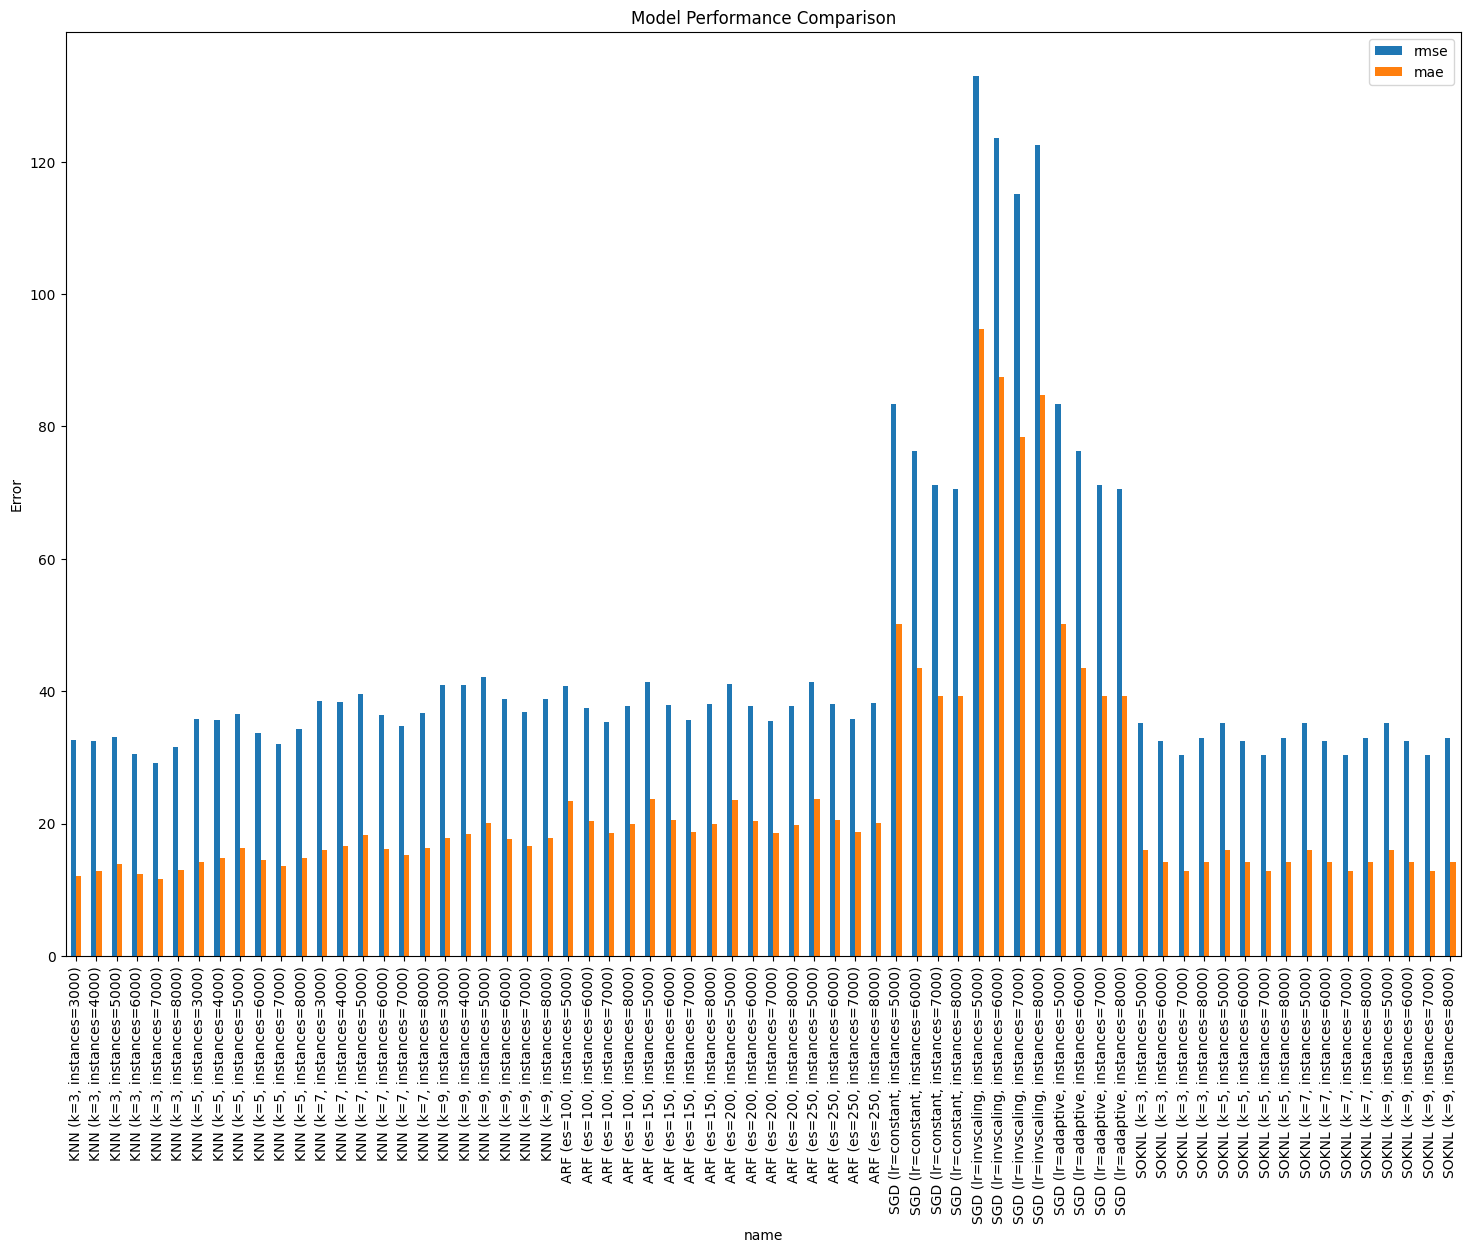

In [ ]:
# Plot performance metrics
metrics_df.plot(kind='bar', x='name', y=['rmse', 'mae'], figsize=(18, 12))
plt.title('Model Performance Comparison')
plt.ylabel('Error')
plt.show()


In [ ]:
# identify the best performing model based on RMSE
best_model_index = metrics_df['rmse'].idxmin()
best_model_name = metrics_df.loc[best_model_index, 'name']
best_model_instances = metrics_df.loc[best_model_index, 'instances']
print(f'\nThe best model based on RMSE: {best_model_name}')


The best model based on RMSE: KNN (k=3, instances=7000)


## Forecast using the best model

In [ ]:

model = knn_models['3,7000']

print(f'\nThe error for predictions made using {best_model_name}: ')
actual_values, predicted_values = forecast(model, stream_test)

# print out the results
print('\nForecasting results:')

for actual, predicted in zip(actual_values, predicted_values):
    print(f'Actual: {actual:.2f} \t\t Predicted: {predicted:.2f}')


Streaming output truncated to the last 5000 lines.
Actual: 0.00 		 Predicted: 1.10
Actual: 0.00 		 Predicted: 0.06
Actual: 0.00 		 Predicted: 0.11
Actual: 0.34 		 Predicted: 1.11
Actual: 0.00 		 Predicted: 1.04
Actual: 0.17 		 Predicted: 0.11
Actual: 0.00 		 Predicted: 0.06
Actual: 0.34 		 Predicted: 0.11
Actual: 0.00 		 Predicted: 0.06
Actual: 0.00 		 Predicted: 0.06
Actual: 0.00 		 Predicted: 0.06
Actual: 0.00 		 Predicted: 0.11
Actual: 0.17 		 Predicted: 0.12
Actual: 0.00 		 Predicted: 0.06
Actual: 0.34 		 Predicted: 0.06
Actual: 0.00 		 Predicted: 0.00
Actual: 0.00 		 Predicted: 0.17
Actual: 0.00 		 Predicted: 0.17
Actual: 0.00 		 Predicted: 0.11
Actual: 0.00 		 Predicted: 0.11
Actual: 0.00 		 Predicted: 0.06
Actual: 0.17 		 Predicted: 0.11
Actual: 1.44 		 Predicted: 0.06
Actual: 1.07 		 Predicted: 0.59
Actual: 0.00 		 Predicted: 0.00
Actual: 0.34 		 Predicted: 0.48
Actual: 0.00 		 Predicted: 0.17
Actual: 0.03 		 Predicted: 0.00
Actual: 0.00 		 Predicted: 0.59
Actual: 0.00 		 Predi

## plot the actual vs predicted values

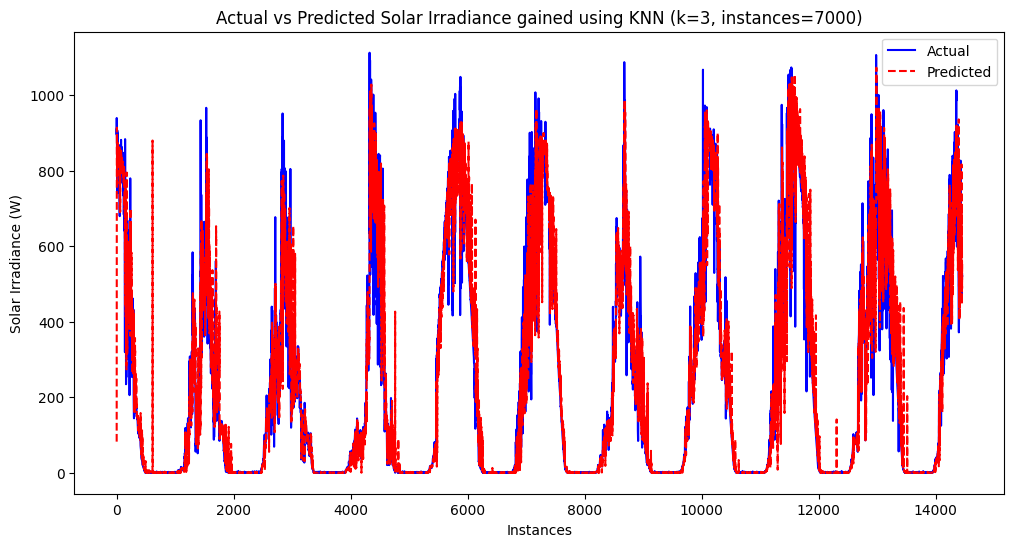

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual', color='blue')
plt.plot(predicted_values, label='Predicted', color='red', linestyle='dashed')
plt.legend()
plt.xlabel('Instances')
plt.ylabel('Solar Irradiance (W)')
plt.title('Actual vs Predicted Solar Irradiance gained using ' + best_model_name)
plt.show()